In [ ]:
import pickle

from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from nanoepitools.reference_cpgs import ReferenceCpGs

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from benchmark_pycometh.config import module_config
from benchmark_pycometh.diffmet.asm_results import Results

In [8]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs(module_config.reference)
m5_path = module_config.meth5_template_file.format(sample="HG002")
results_cache_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/pycometh/asm/all_results_cache.pkl"
load_from_cache=True

In [ ]:
def get_result_file(caller, segmentation=None, test=None, ihw=False, segments_per_window=None, window_size=None):
    basedir = Path("/home/r933r/data/projects/nanopore/pycometh_benchmark/")

    if caller == "methcp":
        return basedir.joinpath("bs/mock_bsseq_from_nanopore/HG002_mockbsseq_segments_methcp_diffmet.tsv")

    basedir = basedir.joinpath("pycometh/asm")

    ihw = f"ihw_{'yes' if ihw else 'no'}"
    if segmentation == "pycometh":
        fn = f"HG002_diffmet_{window_size}_{segments_per_window}_hyp_{test}_{ihw}.tsv"
        return basedir.joinpath("cpg", "diffmet", fn)

    basedir = basedir.joinpath(f"diffmet_{segmentation}/cpg")
    fn = f"HG002_diffmet_hyp_{test}_{ihw}.tsv"
    return basedir.joinpath(fn)

def get_all_result_files():
    yield {"key":"MethCP", "file":get_result_file("methcp", "methcp"), "caller": "methcp"}
    for label, segmentation in  ("PycoMeth", "pycometh"), ("PycoMeth (MethylKit)", "methylkit"), ("PycoMeth (MethCP)", "methcp"):
        for ihw in True, False:
            for test_label, test in ("BS Diff", "bs_diff"), ("LLR-Diff", "llr_diff"), ("Fisher-E","count_dependency"):
                name = f"{label} {test_label}{' (IHW)' if ihw else ''}"
                if segmentation == "pycometh":
                    yield {"key": name + " coarse", "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 12, 300)}
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw, 20, 300)}
                else:
                    yield {"key": name, "caller": "pycometh", "file": get_result_file("pycometh", segmentation, test, ihw)}

if load_from_cache:
    with open(results_cache_file, "rb") as f:
        results = pickle.load(f)
else:
    results = Results(reference_cpgs, m5_path, include_chroms={"21"})

for res_config in get_all_result_files():
    if res_config["key"] not in results.segments:
        results.load_segments(**res_config)

with open(results_cache_file, "bw") as f:
    pickle.dump(results, f)

In [17]:
results.colors = {}
for key in results.segments:
    if key == "MethCP":
        results.colors[key] = "#88498F"
    elif "(MethCP)" in key:
        results.colors[key] = "#C492B1"
    elif "(MethylKit)" in key:
        results.colors[key] = "#49C6E5"
    elif "coarser" in key:
        results.colors[key] = "#C96300"
    elif "coarse" in key:
        results.colors[key] = "#ED7400"
    else:
        results.colors[key] = "#D58936"

results.patterns = {}
for key in results.segments:
    if "LLR-Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "O"
        else:
            results.patterns[key] = "/"
    elif "BS Diff" in key:
        if "IHW" in key:
            results.patterns[key] = "."
        else:
            results.patterns[key] = "\\"
    elif "Fisher-E" in key:
        if "IHW" in key:
            results.patterns[key] = "o"
        else:
            results.patterns[key] = "-"
    else:
        results.patterns[key] = ""

In [44]:
def get_dmrs(key, pval_thres = 0.05, min_diff = 0.1):
    segments = results.segments[key]
    segments = segments.loc[segments["adj_pvalue"] < pval_thres]
    segments = segments.loc[segments["diffmet"].map(lambda x: abs(x) > min_diff)]
    return segments

def get_num_dmr_cpgs(key, **kwargs):
    dmrs = get_dmrs(key, **kwargs)
    return len(unions(dmrs["CpGs"]))

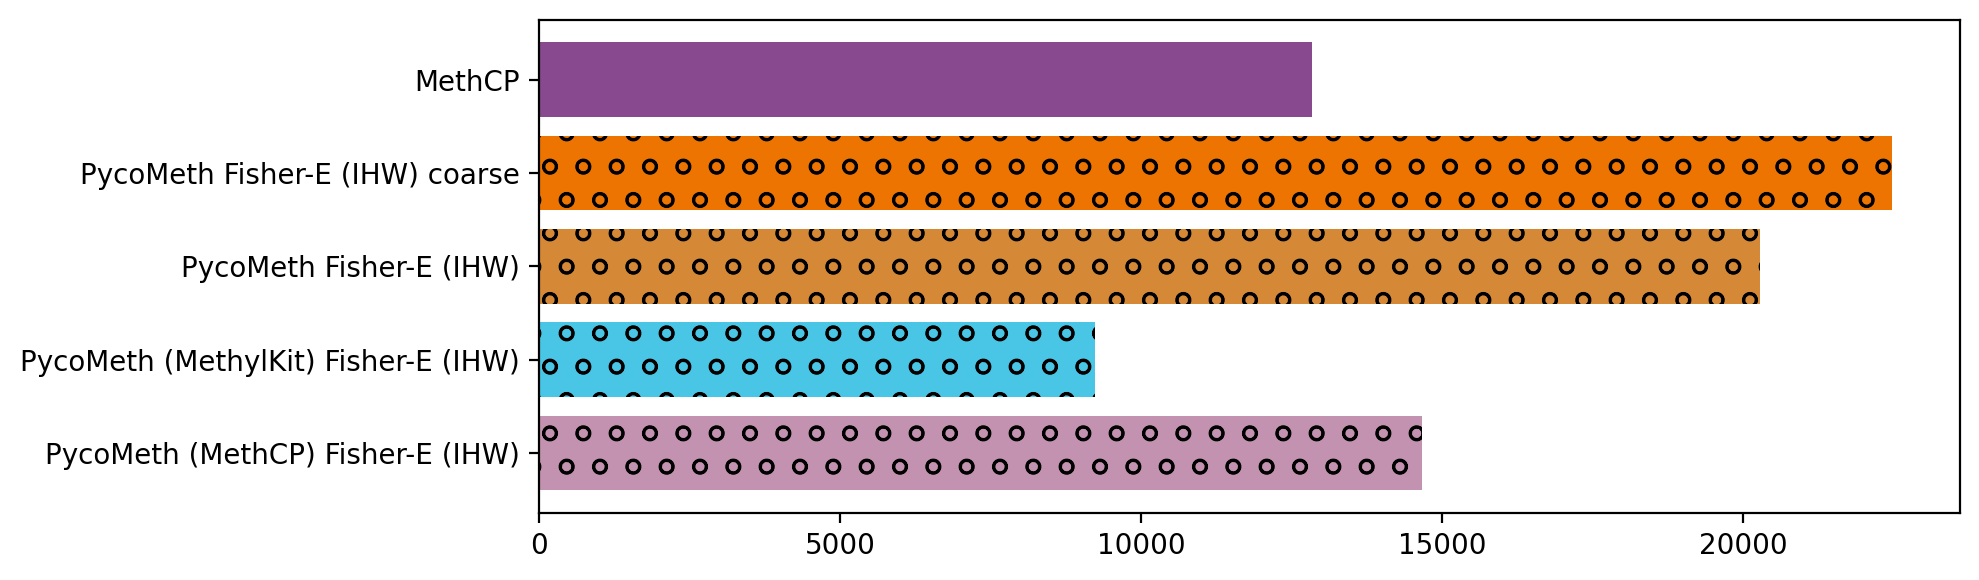

In [58]:
with pa.open_multipage_pdf("asm_hg002_fisher_ihw"):
    tools = ["MethCP", 'PycoMeth Fisher-E (IHW) coarse', 'PycoMeth Fisher-E (IHW)', 'PycoMeth (MethylKit) Fisher-E (IHW)', 'PycoMeth (MethCP) Fisher-E (IHW)'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plt.barh(i, get_num_dmr_cpgs(tool), color = results.colors[tool], hatch=results.patterns[tool])
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

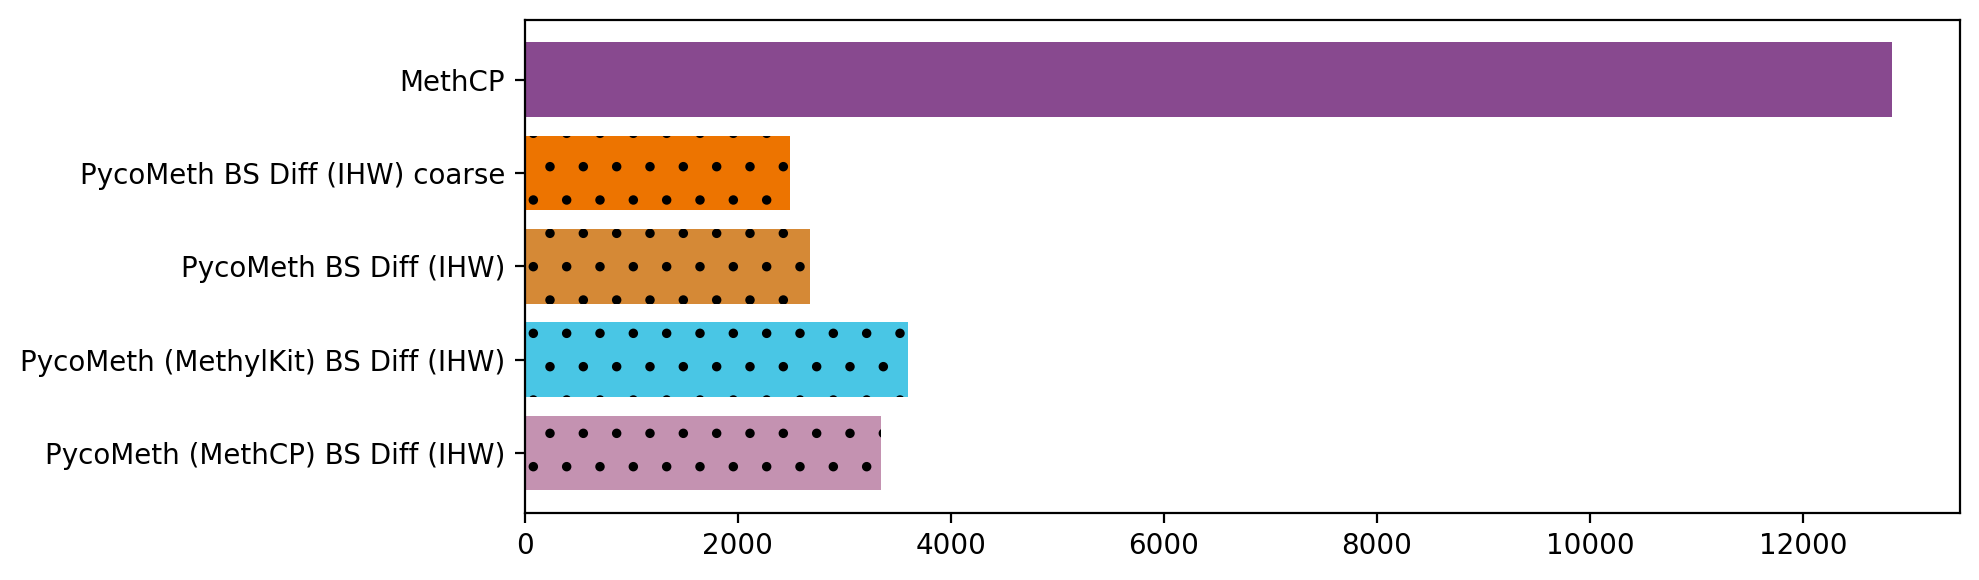

In [59]:
with pa.open_multipage_pdf("asm_hg002_bs_diff_ihw"):
    tools = ["MethCP", 'PycoMeth BS Diff (IHW) coarse', 'PycoMeth BS Diff (IHW)', 'PycoMeth (MethylKit) BS Diff (IHW)', 'PycoMeth (MethCP) BS Diff (IHW)'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plt.barh(i, get_num_dmr_cpgs(tool), color = results.colors[tool], hatch=results.patterns[tool])
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

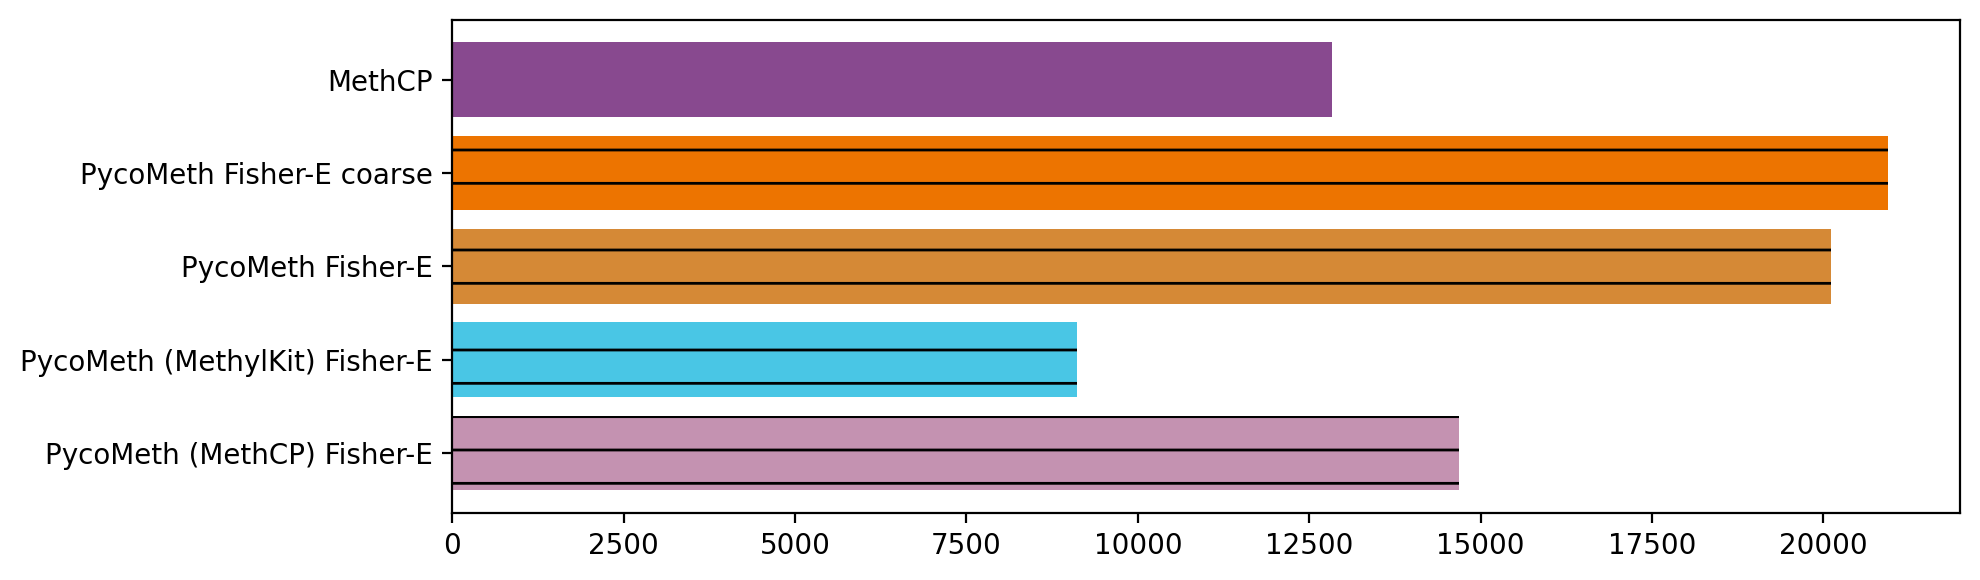

In [60]:
with pa.open_multipage_pdf("asm_hg002_fisher"):
    tools = ["MethCP", 'PycoMeth Fisher-E coarse', 'PycoMeth Fisher-E', 'PycoMeth (MethylKit) Fisher-E', 'PycoMeth (MethCP) Fisher-E'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plt.barh(i, get_num_dmr_cpgs(tool), color = results.colors[tool], hatch=results.patterns[tool])
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

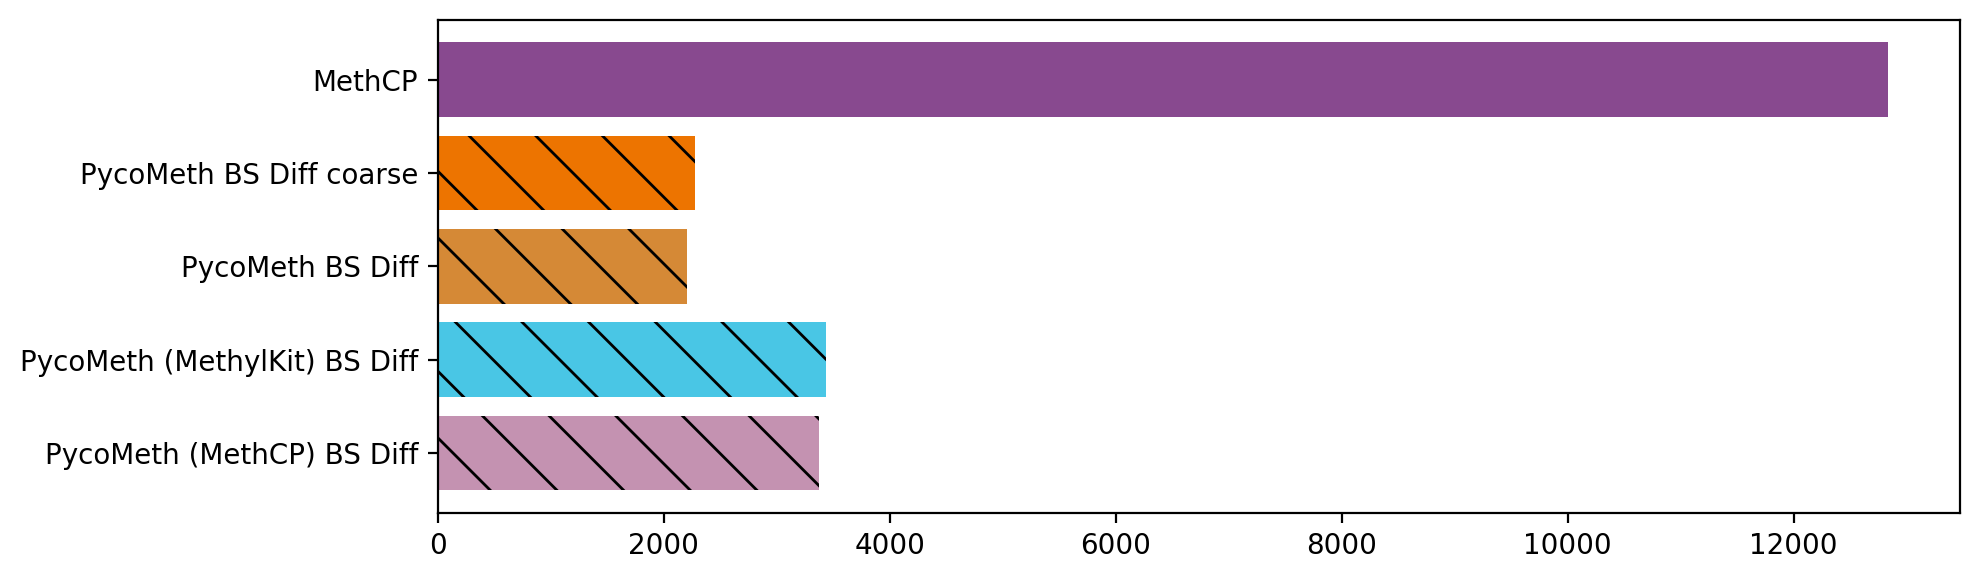

In [61]:
with pa.open_multipage_pdf("asm_hg002_bs_diff"):
    tools = ["MethCP", 'PycoMeth BS Diff coarse', 'PycoMeth BS Diff', 'PycoMeth (MethylKit) BS Diff', 'PycoMeth (MethCP) BS Diff'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plt.barh(i, get_num_dmr_cpgs(tool), color = results.colors[tool], hatch=results.patterns[tool])
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

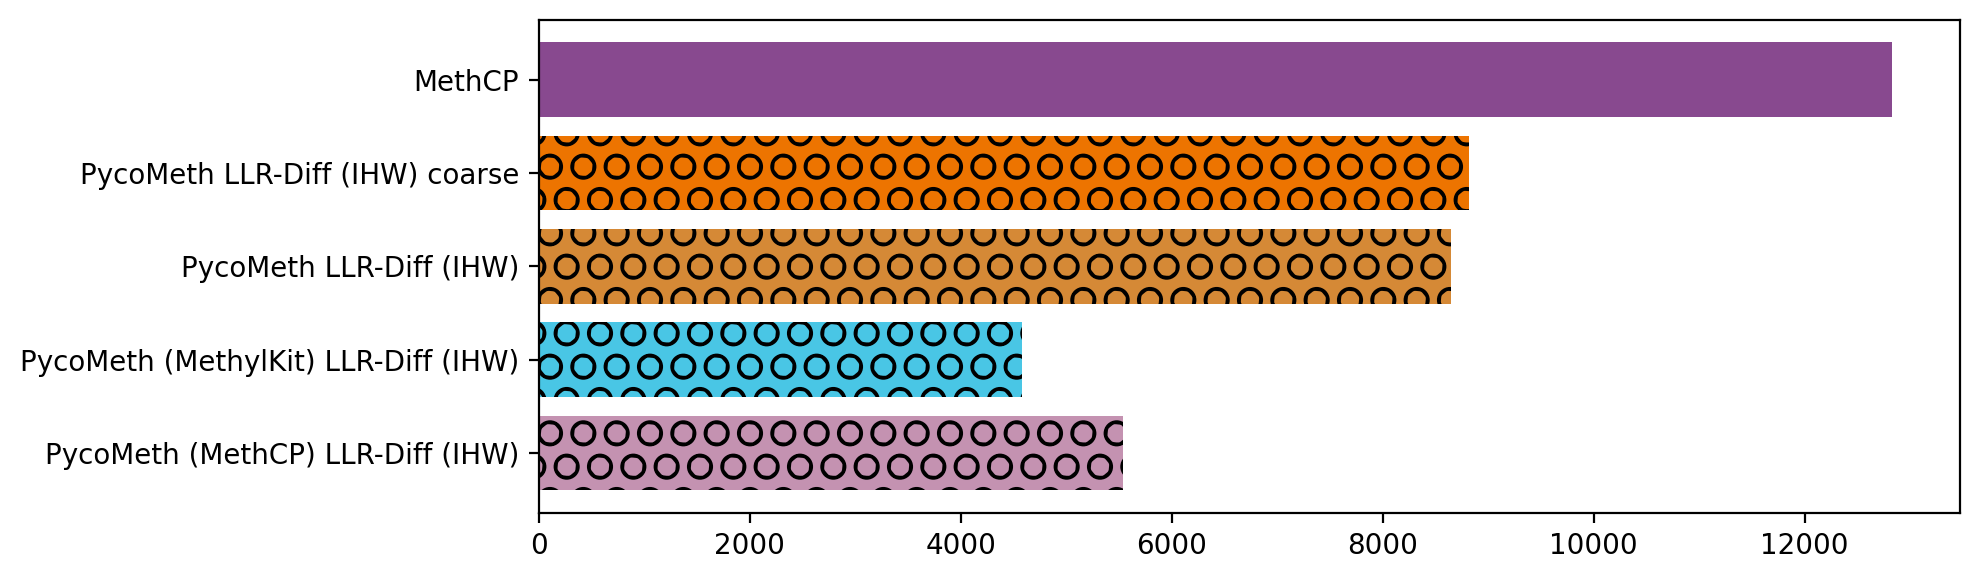

In [62]:
with pa.open_multipage_pdf("asm_hg002_llr_diff_ihw"):
    tools = ["MethCP", 'PycoMeth LLR-Diff (IHW) coarse', 'PycoMeth LLR-Diff (IHW)', 'PycoMeth (MethylKit) LLR-Diff (IHW)', 'PycoMeth (MethCP) LLR-Diff (IHW)'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plt.barh(i, get_num_dmr_cpgs(tool), color = results.colors[tool], hatch=results.patterns[tool])
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

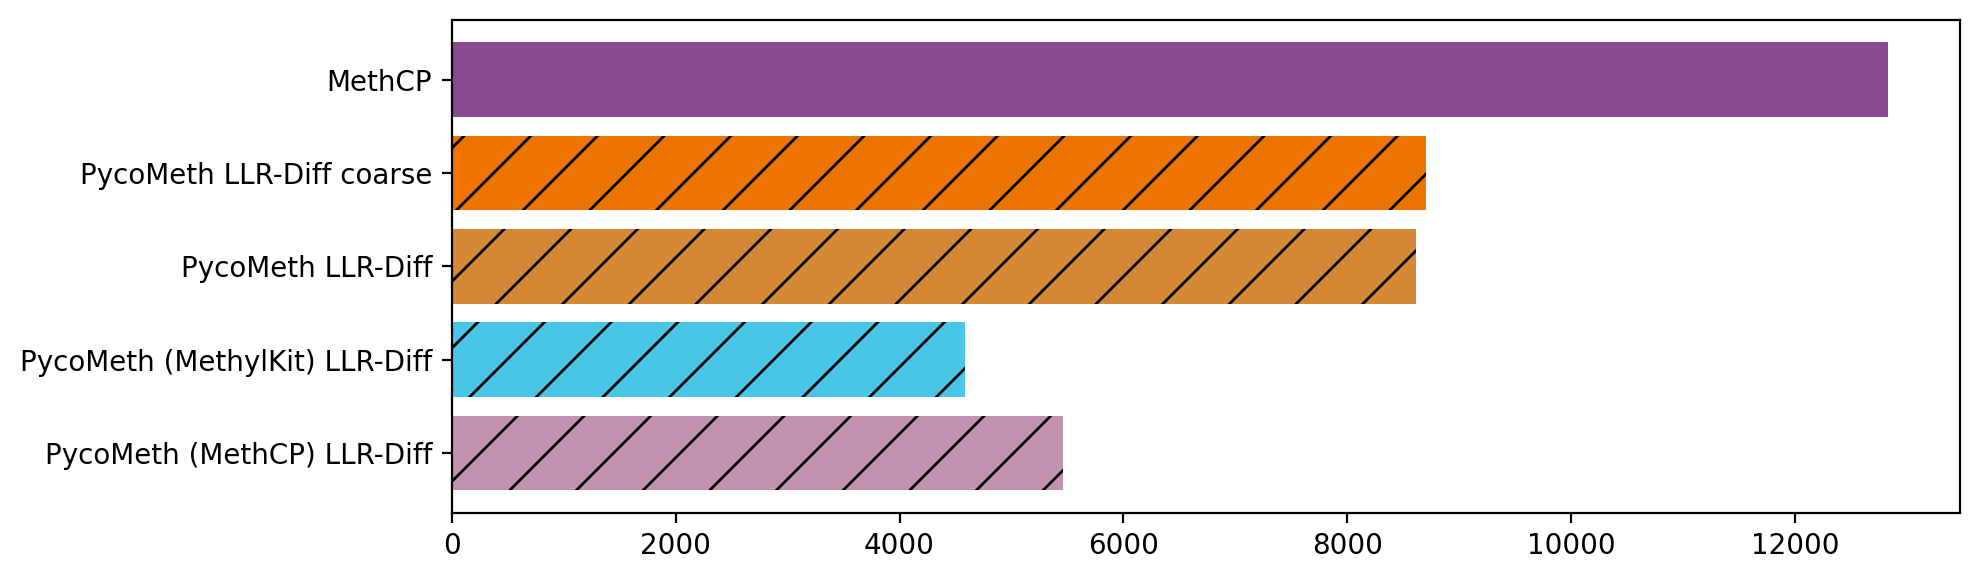

In [63]:
with pa.open_multipage_pdf("asm_hg002_llr_diff"):
    tools = ["MethCP", 'PycoMeth LLR-Diff coarse', 'PycoMeth LLR-Diff', 'PycoMeth (MethylKit) LLR-Diff', 'PycoMeth (MethCP) LLR-Diff'][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plt.barh(i, get_num_dmr_cpgs(tool), color = results.colors[tool], hatch=results.patterns[tool])
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()

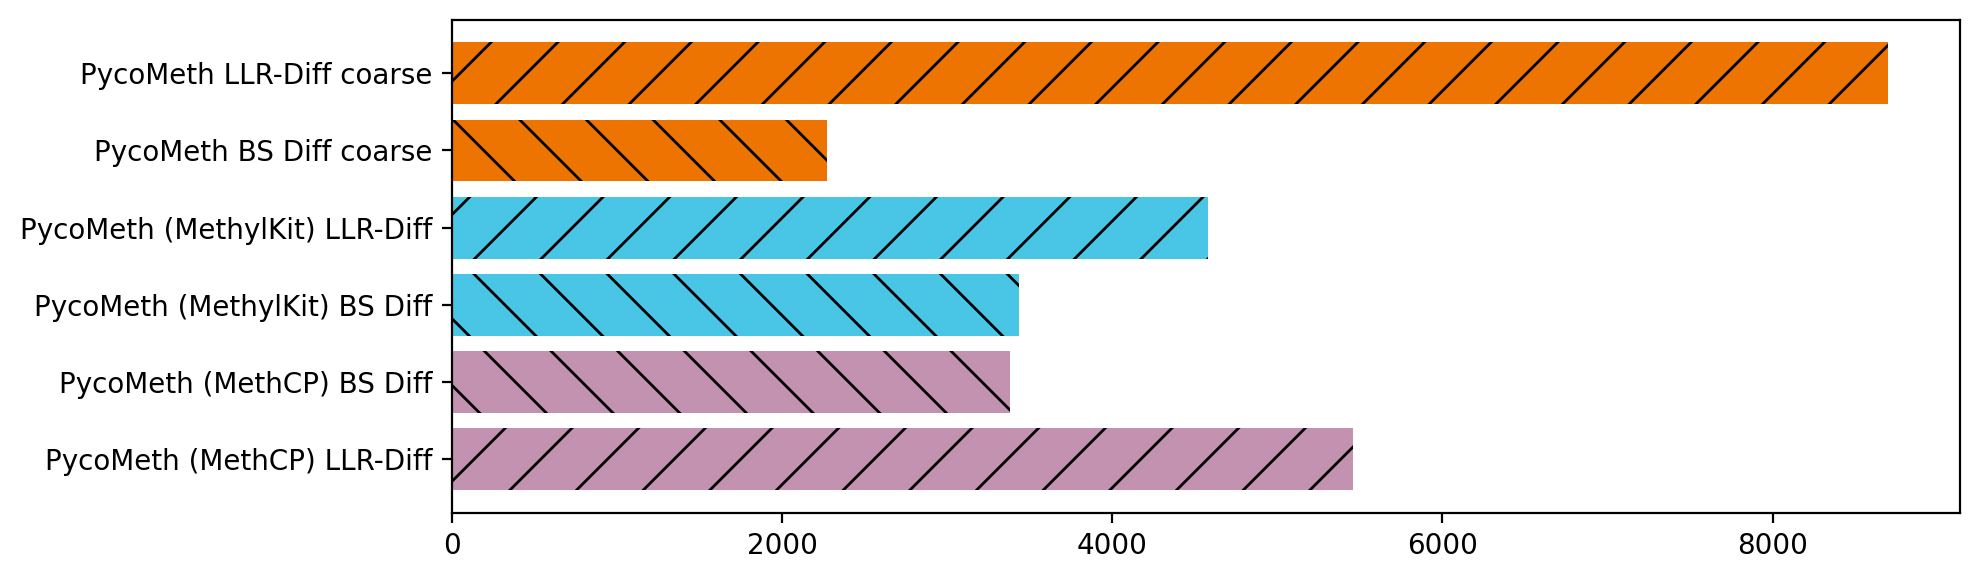

In [64]:
with pa.open_multipage_pdf("asm_hg002_llr_diff_vs_bs_diff"):
    tools = ["PycoMeth LLR-Diff coarse", "PycoMeth BS Diff coarse", "PycoMeth (MethylKit) LLR-Diff", "PycoMeth (MethylKit) BS Diff", "PycoMeth (MethCP) BS Diff", "PycoMeth (MethCP) LLR-Diff"][::-1]
    pa.figure(figsize=(10, 3))
    for i, tool in enumerate(tools):
        plt.barh(i, get_num_dmr_cpgs(tool), color = results.colors[tool], hatch=results.patterns[tool])
    plt.yticks(np.arange(0, len(tools), 1), tools)
    pa.saveandshow()
